In [253]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
from scipy.spatial import Delaunay
from shapely import vectorized
from shapely.geometry import box, Point, MultiPolygon, LineString, MultiLineString
from shapely.strtree import STRtree

from DDV import kernel

In [22]:
data = netCDF4.Dataset('../data/wave_test_data.nc', 'r')

lons = data.variables['model_lons'][:].data
lats = data.variables['model_lats'][:].data
model_vals = data.variables['model_values'][:].data


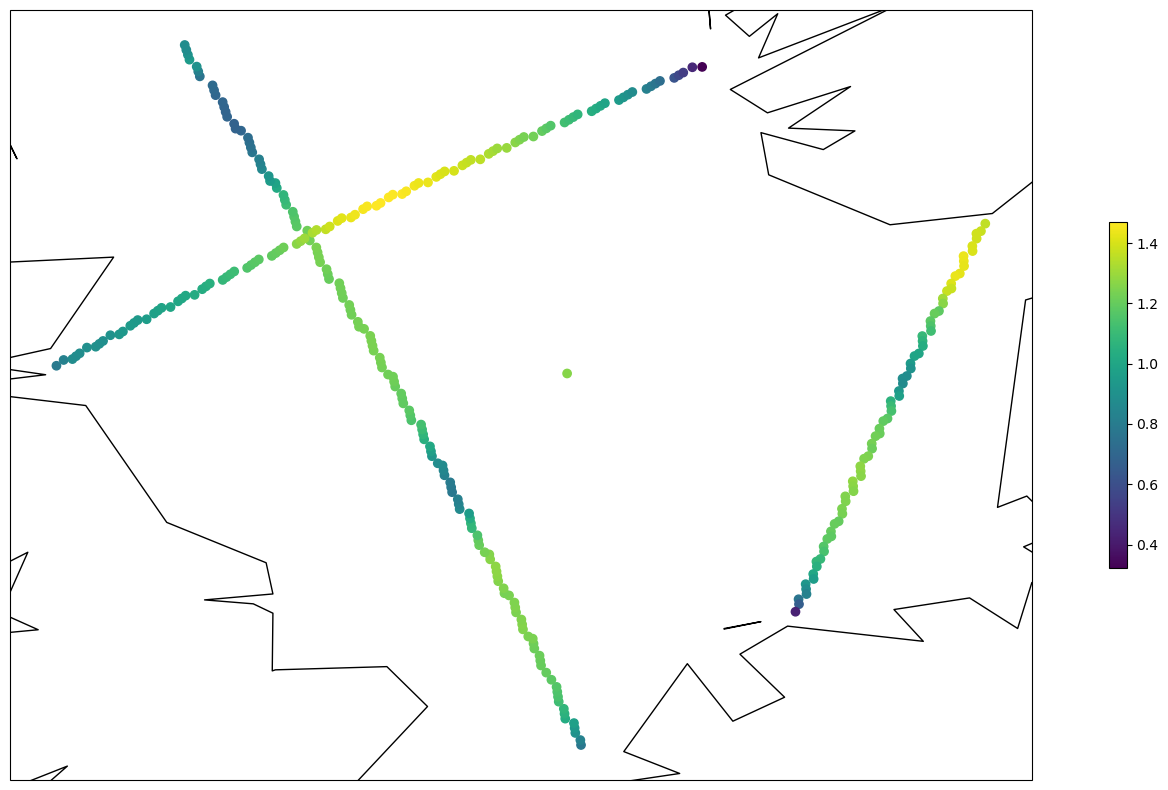

In [389]:
coast = cf.GSHHSFeature(scale="c")

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
ax.add_feature(coast, edgecolor='black', zorder=1)
plt.scatter(lons, lats, c=np.log(model_vals))
plt.colorbar(shrink=0.45)

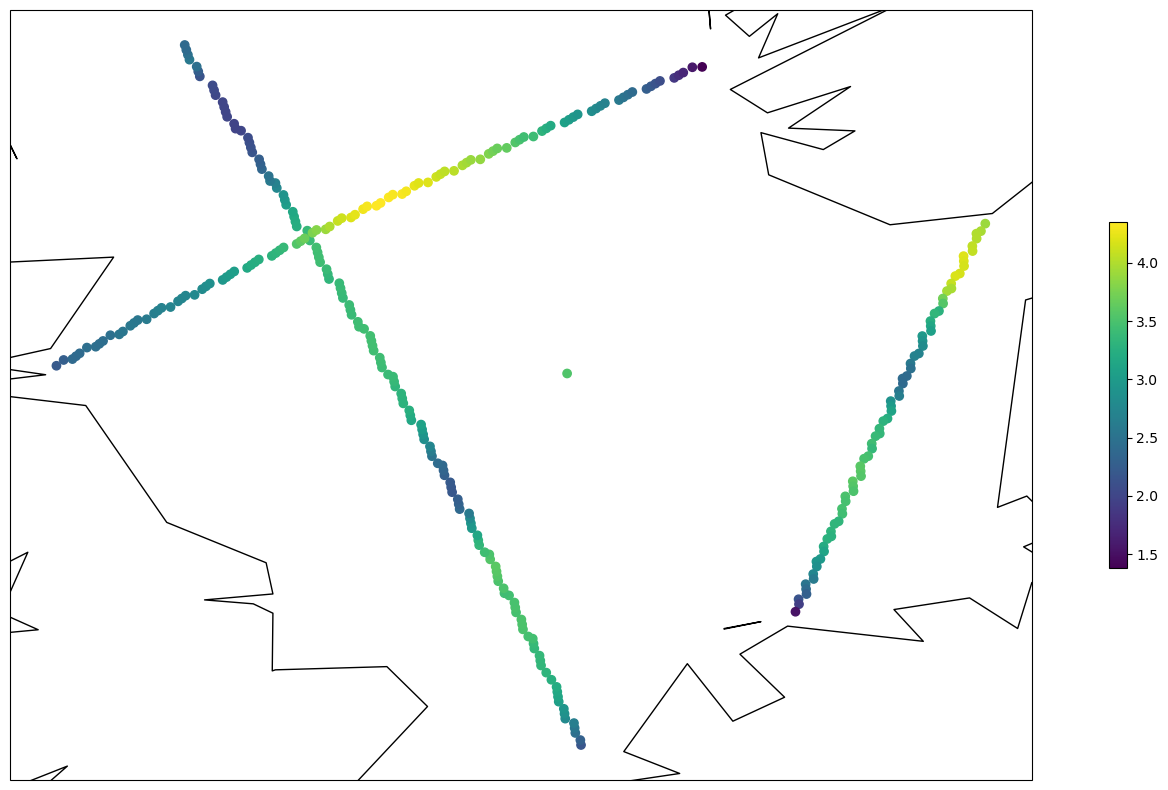

In [390]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
ax.add_feature(coast, edgecolor='black', zorder=1)
plt.scatter(lons, lats, c=(model_vals))
plt.colorbar(shrink=0.45)

In [466]:
buffer = 0.2
bbox = [min(lons) - buffer, max(lons) + buffer, min(lats) - buffer, max(lats) + buffer]
bounding_box = box(*bbox)

In [467]:
def augment_with_boundary(points, offset, N):
    """
    Augments lat/lon points with N points per edge along a boundary box 
    expanded by 'offset' around the original points.
    
    Parameters:
        points (np.ndarray): Nx2 array of [lat, lon] points.
        offset (float): Distance (in degrees) to expand the boundary.
        N (int): Number of points to generate along each boundary edge.
        
    Returns:
        np.ndarray: Original points plus 4*N boundary points.
    """
    lat_min, lon_min = points.min(axis=0) - offset
    lat_max, lon_max = points.max(axis=0) + offset

    # Generate points along each of the 4 edges
    left_edge = np.column_stack([np.linspace(lat_min, lat_max, N), np.full(N, lon_min)])
    right_edge = np.column_stack([np.linspace(lat_min, lat_max, N), np.full(N, lon_max)])
    bottom_edge = np.column_stack([np.full(N, lat_min), np.linspace(lon_min, lon_max, N)])
    top_edge = np.column_stack([np.full(N, lat_max), np.linspace(lon_min, lon_max, N)])

    boundary = np.vstack([left_edge, right_edge, bottom_edge, top_edge])
    return np.vstack([points, boundary])

In [555]:
lons_ls, lats_ls = np.meshgrid(np.linspace(bbox[0], bbox[1], 75), np.linspace(bbox[2], bbox[3], 75))
# lons_grid = np.concatenate((lons, lons_grid.flatten()))
# lats_grid = np.concatenate((lats, lats_grid.flatten()))

pp = np.column_stack((lats_ls.flatten(), lons_ls.flatten()))
aug_points = augment_with_boundary(pp, 0.25, 30)

lats_grid = aug_points[:, 0]
lons_grid = aug_points[:, 1]

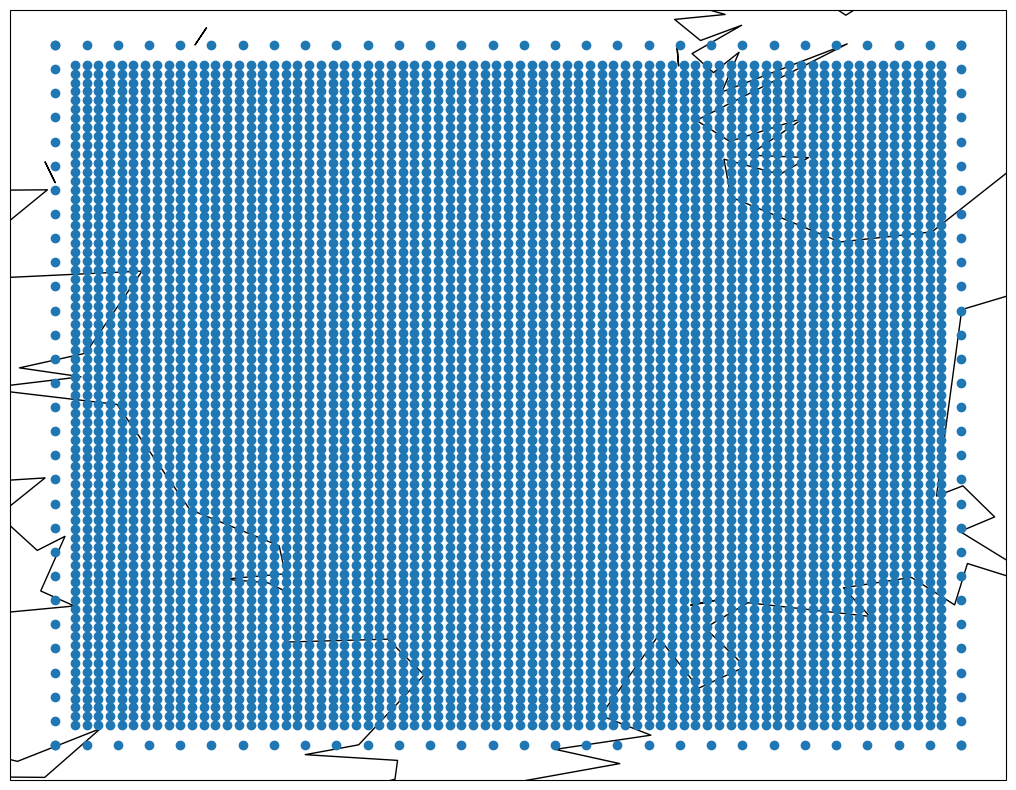

In [556]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
ax.add_feature(coast, edgecolor='black', zorder=1)
plt.scatter(lons_grid, lats_grid)

In [557]:
flat_lons = lons_grid.flatten()
flat_lats = lats_grid.flatten()

coast_union = MultiPolygon(list(coast.geometries()))
coast_boundaries = [poly.boundary for poly in coast_union.geoms]

# Combine into a MultiLineString for edge-crossing checks
coast_lines = MultiLineString(coast_boundaries)
# coast_union = coast_union.buffer(0)
mask = vectorized.contains(coast_union, flat_lons, flat_lats)

# Keep points NOT inside coast
valid_points = np.column_stack([flat_lons[~mask], flat_lats[~mask]])

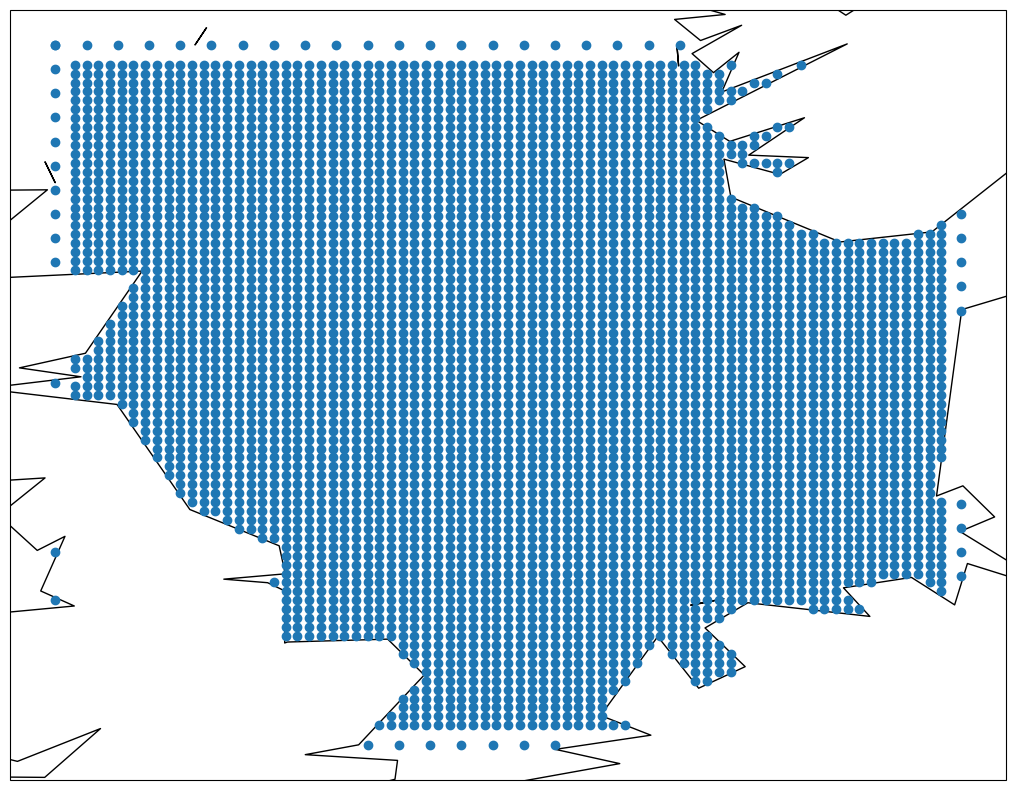

In [558]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
ax.add_feature(coast, edgecolor='black', zorder=1)
plt.scatter(valid_points[:, 0], valid_points[:, 1])

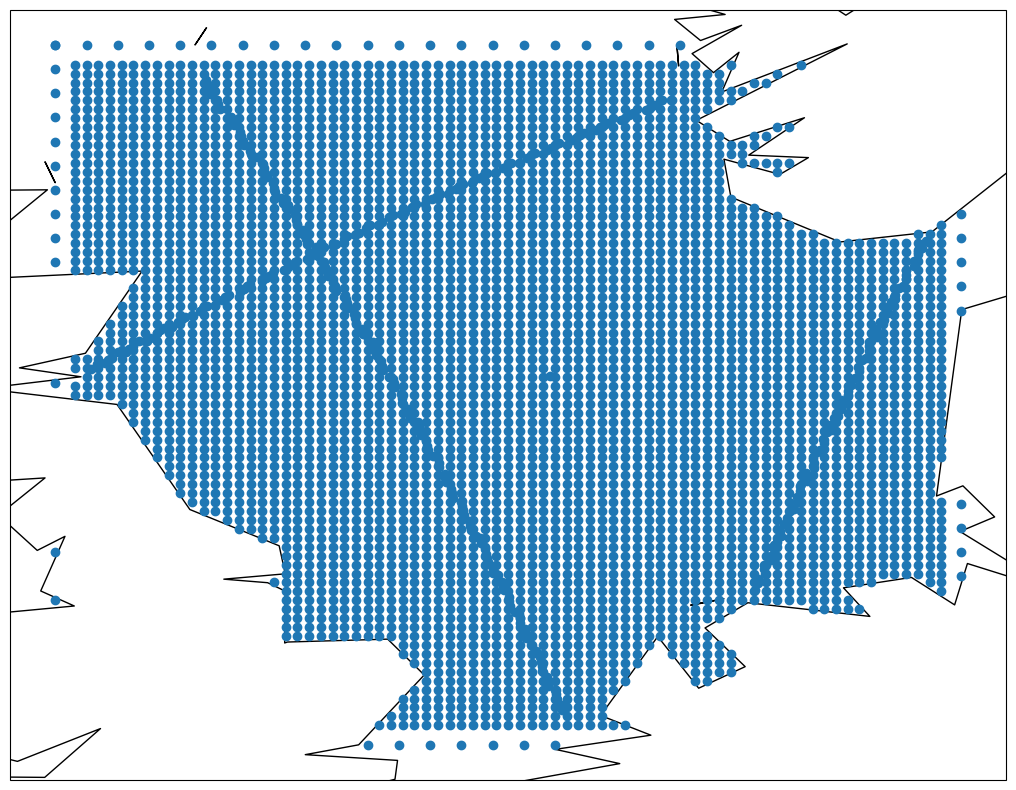

In [561]:
valid_points = np.concatenate((valid_points, np.column_stack((lons, lats))))

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
ax.add_feature(coast, edgecolor='black', zorder=1)
plt.scatter(valid_points[:, 0], valid_points[:, 1])

In [562]:
def filter_valid_triangles_and_points(
        ocean_tri, valid_points, coast_union, boundary_distance=0.0
):
    """
    Filter triangles whose edges do not cross the coastline boundary,
    remove points not belonging to any valid triangle,
    and identify points within boundary_distance of the coastline.

    Parameters:
    - ocean_tri: triangulation object with `.simplices` attribute (Nx3 indices)
    - valid_points: Nx2 array of lat/lon points
    - coast_union: shapely geometry (MultiPolygon or MultiLineString) representing coastline
    - boundary_distance: float, distance threshold to identify boundary points

    Returns:
    - filtered_points: Mx2 array of points used by filtered triangles
    - filtered_triangles: Kx3 array of triangle indices (relative to filtered_points)
    - new_indices: length N array mapping old indices -> new indices or -1 if removed
    - boundary_indices: list of original point indices within boundary_distance of coast
    """

    # Extract boundaries as LineStrings
    if isinstance(coast_union, MultiPolygon):
        boundaries = [poly.boundary for poly in coast_union.geoms]
    elif isinstance(coast_union, MultiLineString):
        boundaries = list(coast_union.geoms)
    elif isinstance(coast_union, LineString):
        boundaries = [coast_union]
    else:
        raise TypeError("coast_union must be MultiPolygon, MultiLineString, or LineString")

    # Flatten MultiLineStrings if any
    boundary_segments = []
    for geom in boundaries:
        if isinstance(geom, LineString):
            boundary_segments.append(geom)
        elif isinstance(geom, MultiLineString):
            boundary_segments.extend(geom.geoms)
        else:
            raise TypeError("Boundary component is not a LineString or MultiLineString")

    # Build spatial index on boundary segments
    coast_index = STRtree(boundary_segments)

    valid_triangles = []

    for simplex in ocean_tri.simplices:
        triangle = valid_points[simplex]

        # Create edges as LineStrings
        edges = [
            LineString([triangle[0], triangle[1]]),
            LineString([triangle[1], triangle[2]]),
            LineString([triangle[2], triangle[0]])
        ]

        # Check if any edge crosses any nearby coastline segment
        crossed = False
        for edge in edges:
            candidate_indices = coast_index.query(edge)  # returns indices
            candidates = [boundary_segments[i] for i in candidate_indices]
            if any(edge.crosses(seg) for seg in candidates):
                crossed = True
                break

        if not crossed:
            valid_triangles.append(simplex)

    valid_triangles = np.array(valid_triangles)

    # Find unique vertices used by valid triangles
    used_vertex_indices = np.unique(valid_triangles.flatten())

    # Map old vertex indices to new indices (or -1 if not used)
    new_indices = -np.ones(len(valid_points), dtype=int)
    new_indices[used_vertex_indices] = np.arange(len(used_vertex_indices))

    # Remap triangle vertex indices to filtered points indices
    filtered_triangles = new_indices[valid_triangles]

    # Filter points to only those used
    filtered_points = valid_points[used_vertex_indices]

    # Identify points within boundary_distance of coast line
    boundary_indices = []
    if boundary_distance > 0:
        # Create Point objects for all valid_points (original indices)
        point_geoms = [Point(p) for p in valid_points]

        # Use spatial index to speed up distance checks:
        for idx, pt in enumerate(point_geoms):
            # Query candidates near this point with a small envelope buffer
            candidates_idx = coast_index.query(pt.buffer(boundary_distance))
            candidates = [boundary_segments[i] for i in candidates_idx]

            # Check if point is within boundary_distance of any candidate segment
            if any(pt.distance(seg) <= boundary_distance for seg in candidates):
                boundary_indices.append(idx)

    return filtered_points, filtered_triangles, new_indices, np.array(boundary_indices, dtype=int)


ocean_tri = Delaunay(valid_points)

valid_points, valid_triangles, index_map, boundary_indices = filter_valid_triangles_and_points(
    ocean_tri, valid_points, coast_union, 0.1
)

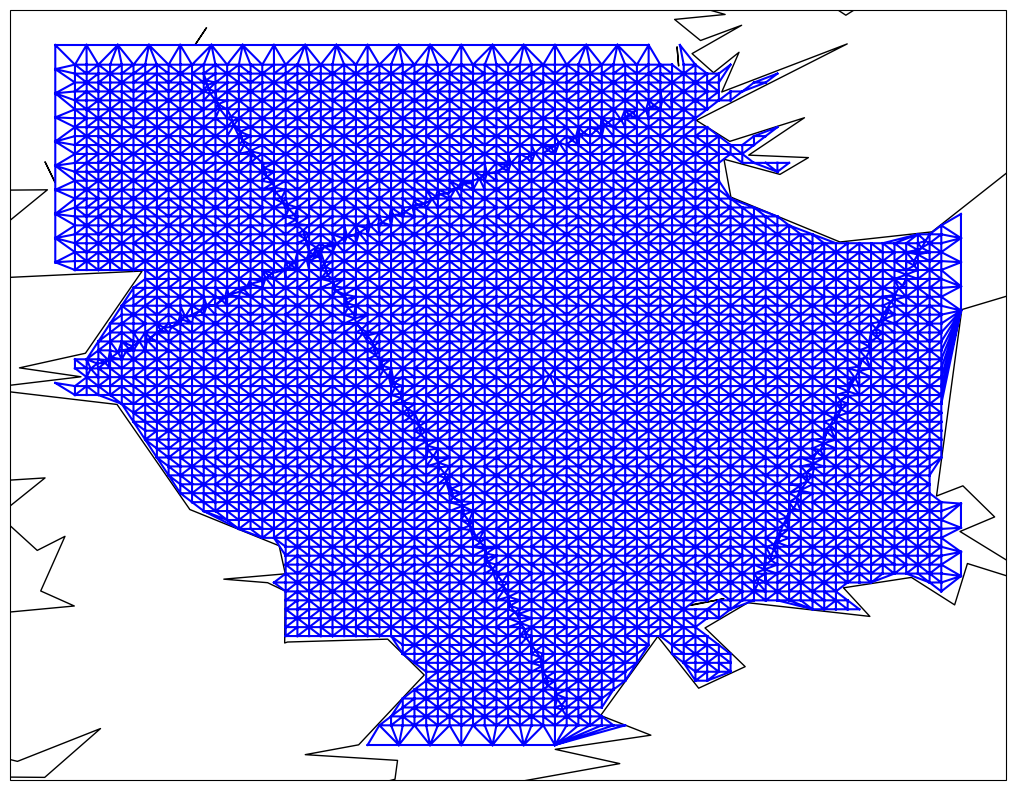

In [563]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
ax.add_feature(coast, edgecolor='black', zorder=1)
plt.triplot(valid_points[:, 0], valid_points[:, 1], valid_triangles, color='blue')
# plt.scatter(valid_points[:, 0], valid_points[:, 1], color='red')

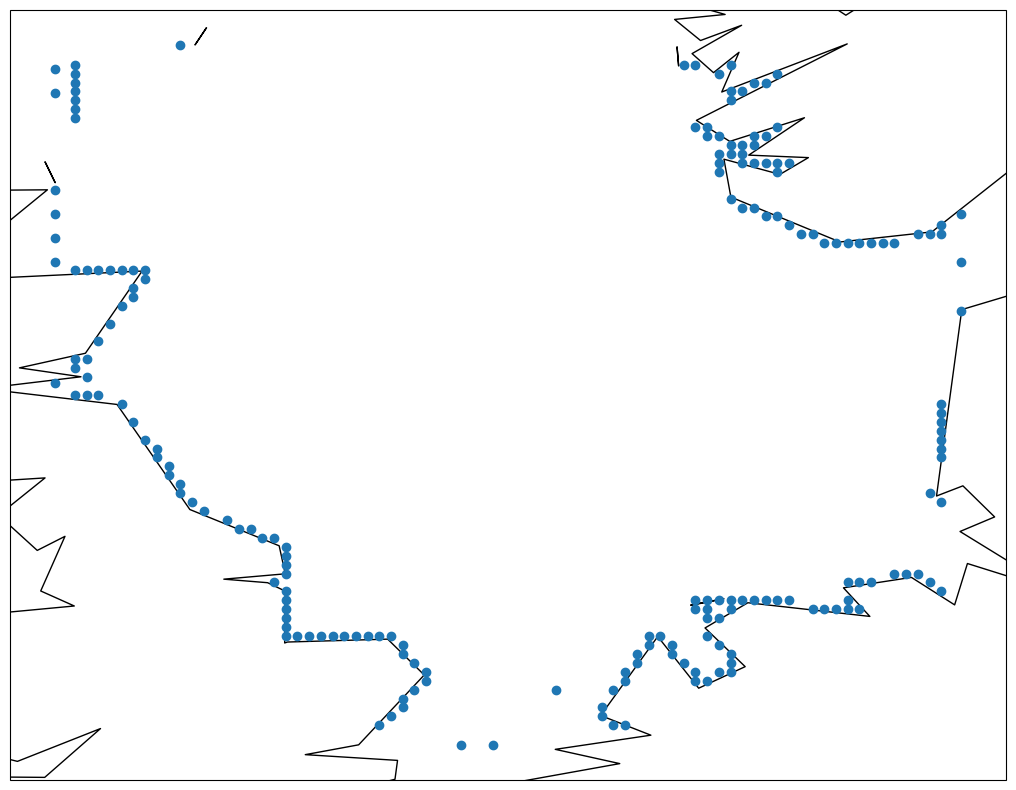

In [564]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
ax.add_feature(coast, edgecolor='black', zorder=1)
plt.scatter(valid_points[boundary_indices, 0], valid_points[boundary_indices, 1])

In [565]:
import pydec
import scipy.sparse


def generate_scalar_basis(vertices, simplices, boundary=None, flat=False, tolerance=1e-10,
                          depth=None):
    complex = pydec.SimplicialComplex((vertices, simplices))

    complex.construct_hodge()

    L = complex[0].d.T @ complex[1].star @ complex[0].d

    if depth is None:
        depth = len(complex.vertices) - 2

    if not flat:
        eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(A=L, M=complex[0].star,
                                                              k=depth,
                                                              sigma=0,
                                                              mode='normal',
                                                              tol=tolerance,
                                                              ncv=min(4 * depth, L.shape[0] - 1)
                                                              )
    else:
        if boundary is None:
            eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(A=L,
                                                                  k=depth,
                                                                  sigma=0,
                                                                  mode='normal',
                                                                  tol=tolerance,
                                                                  ncv=min(4 * depth, L.shape[0] - 1)
                                                                  )
        else:
            interior_vertices = np.full(L.shape[0], True)
            interior_vertices[boundary] = False

            # Extract interior submatrix
            L_ii = L[np.ix_(interior_vertices, interior_vertices)]

            # Recompute eigenvectors with Dirichlet zero boundary condition
            eigenvalues, eigvecs_int = scipy.sparse.linalg.eigsh(A=L_ii,
                                                                 k=depth,
                                                                 sigma=0,
                                                                 mode='normal',
                                                                 tol=tolerance,
                                                                 ncv=min(4 * depth, L.shape[0] - 1)
                                                                 )

            # Assemble full eigenvectors with zero at boundary
            eigenvectors = np.zeros((L.shape[0], depth))
            eigenvectors[interior_vertices, :] = eigvecs_int

    eigenvalues[abs(eigenvalues) < tolerance] = 0

    vol = np.sum(complex[-1].primal_volume)

    return eigenvalues, eigenvectors, vol, complex

In [566]:
eigenvalues, eigenvectors, vol, complex = generate_scalar_basis(valid_points, valid_triangles,
                                                                boundary=boundary_indices, flat=True, depth=300)

C:\Users\mg874\anaconda3\Lib\site-packages\pydec\dec\simplicial_complex.py:177: RuntimeWarning: divide by zero encountered in divide
  data.star_inv = sparse.spdiags([1.0/stardiag],[0], N, N, format='csr')


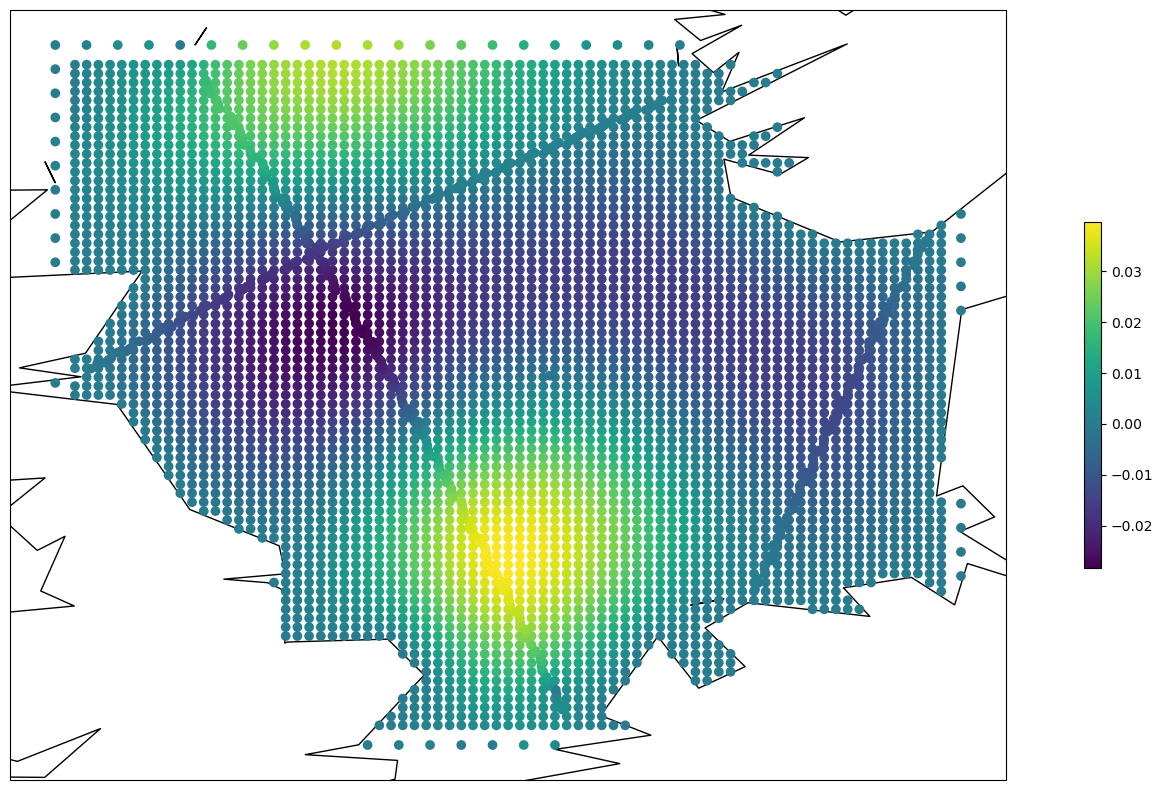

In [567]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
ax.add_feature(coast, edgecolor='black', zorder=1)
plt.scatter(valid_points[:, 0], valid_points[:, 1], c=eigenvectors[:, 4])
plt.colorbar(shrink=0.45)

In [568]:
def scalar_mesh_kernel(eigenvalues, eigenvectors, points_1, points_2, dim, params, vol, mass_matrix):
    ms = kernel.matern_scaling(eigenvalues[1:], params["k"], params["v"], dim)

    c = sum(ms[1:]) / vol

    s1 = eigenvectors[points_1, 1:]
    s2 = eigenvectors[points_2, 1:]
    D = np.diag(ms)
    K = (params["s"] ** 2 / c) * (s1 @ D @ s2.T)

    return K


def predict_scalars(eigenvalues, eigenvectors, mass_matrix, obs_idx, pred_idx, z_obs, dim, params,
                    vol, tau=1e-6, cov=False):
    K_vec_x_x = scalar_mesh_kernel(eigenvalues, eigenvectors, obs_idx, obs_idx, dim, params, vol, mass_matrix)
    K_vec_x_x = K_vec_x_x + tau * np.eye(len(obs_idx))

    print(f"Condition number of K_vec_x_x: {np.linalg.cond(K_vec_x_x):.2e}")

    # obs to everything
    K_vec_x_x_star = scalar_mesh_kernel(eigenvalues, eigenvectors, obs_idx, pred_idx, dim, params, vol, mass_matrix)

    post_cov = None

    if cov:
        print("Generating posterior covariance...")
        K_vec_x_star_x_star = scalar_mesh_kernel(eigenvalues, eigenvectors, pred_idx,
                                                 pred_idx, dim, params, vol, mass_matrix)
        K_vec_x_star_x_star = K_vec_x_star_x_star + tau * np.eye(len(pred_idx))
        print(f"Condition number of K_vec_x_star_x_star: {np.linalg.cond(K_vec_x_star_x_star):.2e}")
        eigs = np.linalg.eigvalsh(K_vec_x_star_x_star)
        print("min eigval:", np.min(eigs))
        print("rank (eig > 1e-10):", np.sum(eigs > 1e-10), "/", len(eigs))
        post_cov = K_vec_x_star_x_star - K_vec_x_x_star.T @ np.linalg.solve(K_vec_x_x, K_vec_x_x_star)

    post_mean = K_vec_x_x_star.T @ scipy.linalg.solve(K_vec_x_x, z_obs)

    return post_mean, post_cov

In [585]:
pred_idx = range(valid_points.shape[0])
obs_idx = range(valid_points.shape[0] - len(model_vals), valid_points.shape[0])

params = {
    "k": 10,
    "s": np.std(model_vals),
    "v": 2.5
}

post_mean, post_cov = predict_scalars(eigenvalues, eigenvectors, complex[0].star.todense(), obs_idx, pred_idx,
                                      np.log(model_vals), 2, params, vol, tau=1e-4, cov=True)

Condition number of K_vec_x_x: 4.62e+03
Generating posterior covariance...
Condition number of K_vec_x_star_x_star: 4.22e+04
min eigval: 9.999999999915236e-05
rank (eig > 1e-10): 4641 / 4641


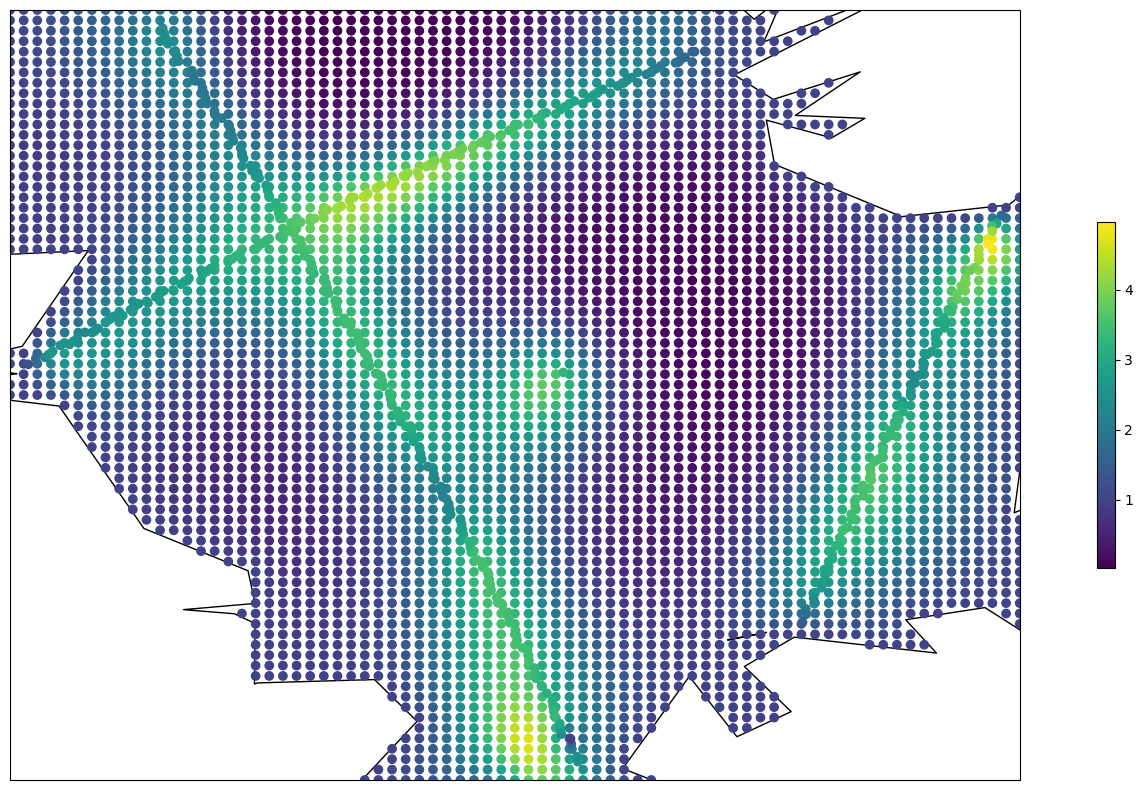

In [586]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
ax.add_feature(coast, edgecolor='black', zorder=1)
plt.scatter(valid_points[:, 0], valid_points[:, 1], c=np.exp(post_mean))
plt.colorbar(shrink=0.45)
ax.set_extent(bbox)

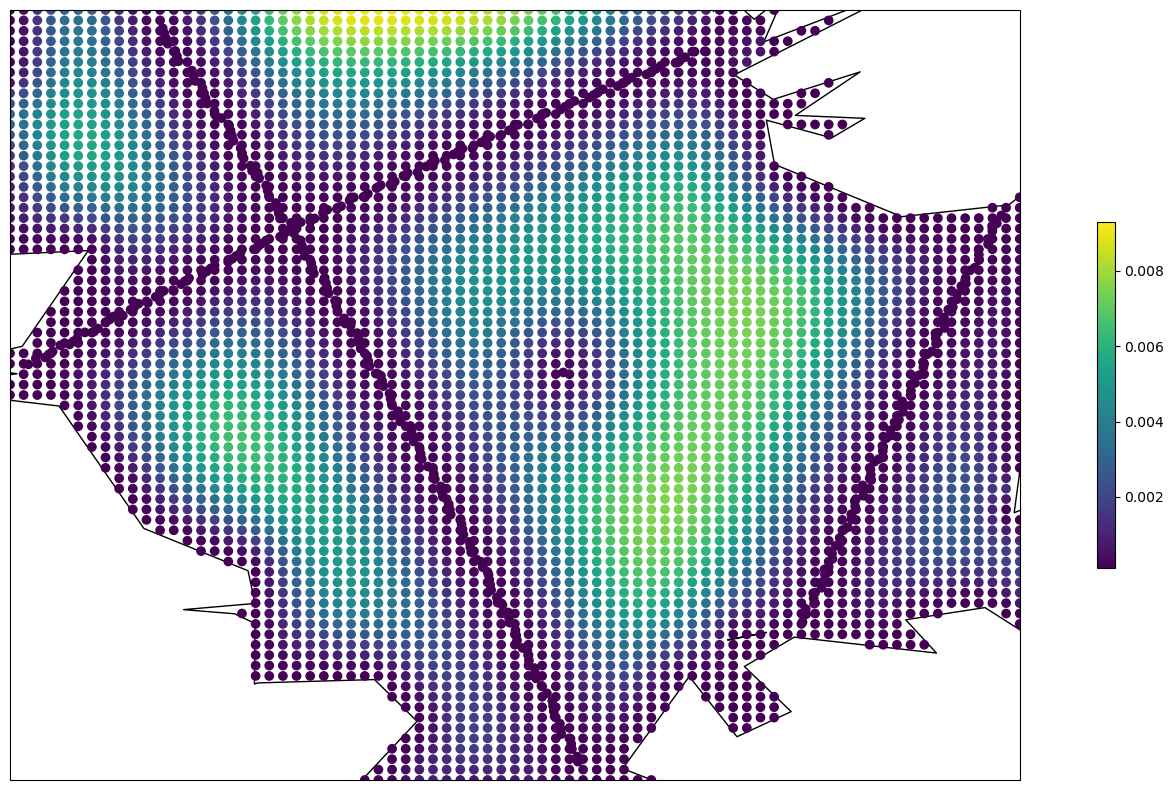

In [587]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
ax.add_feature(coast, edgecolor='black', zorder=1)
plt.scatter(valid_points[:, 0], valid_points[:, 1], c=np.diag(post_cov))
plt.colorbar(shrink=0.45)
ax.set_extent(bbox)